In [87]:
%matplotlib inline
import numpy as np
import keras.backend as K
import bcolz
import matplotlib.pyplot as plt

from PIL import Image
from keras.applications import vgg16
from keras.layers import *
from keras.models import Model
from keras import optimizers

rmean is the mean value of rgb from ImageNet

In [71]:
rmean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
preproc = lambda x: (x - rmean)[:,:,:,::-1]

In [72]:
def conv_block(input_data, filter_size, kernal_size = 3, border_mode = 'same', stride = (1,1), activate = True):
    x = Convolution2D(filter_size, kernal_size, kernal_size, 
                      subsample = stride, border_mode = border_mode)(input_data)
    x = BatchNormalization(mode = 2)(x)
    return Activation('relu')(x) if activate else x

In [73]:
def res_block(input_data, filter_size = 64):
    x = conv_block(input_data, filter_size)
    x = conv_block(x, filter_size, activate = False)
    return merge([input_data, x], mode='sum')

In [74]:
def up_block(input_data, filter_size = 64):
    x = UpSampling2D()(input_data)
    x = Convolution2D(filter_size, 3, 3, border_mode='same')(x)
    x = BatchNormalization(mode=2)(x)
    return Activation('relu')(x)

This mean_sqr function add all of the elements of the input together and divide by the number of elements. 
K.mean((x1-x2)(x1-x2), dims) will return mean of every batchs(one dim only).

In [75]:
#Example of K.mean, mean of numpy have same semantic and results as K.mean:
shape = (2,2,2,2)
cimg = np.arange(16)
cimg = cimg.reshape(shape)
print(np.mean(cimg, (1,2,3)))
#end of Example of K.mean

[  3.5  11.5]


In [76]:
def mean_sqr_b(x1, x2):
    dims = list(range(1, K.ndim(x1)))
    return K.expand_dims(K.sqrt(K.mean((x1-x2)**2, dims)), 0)

Perceptual loss is the content loss of some layers, this formula is listed at equation 1 of the paper
[Perceptual Losses for Real-Time Style Transfer and Super-Resolution](https://arxiv.org/pdf/1603.08155.pdf)

In [77]:
loss_weight = [0.1, 0.8, 0.1]
def perceptual_loss(input_data):
    n = len(loss_weight)
    result = 0
    #input_data[i] is the output value of low/high resolution image associate with input_data[i+n]
    #input_data[i + n] is the output value of low/high resolution image associate with input_data[i]
    for i in range(n): result += mean_sqr_b(input_data[i], input_data[i+n]) * loss_weight[i]
    return result

In [78]:
dpath = '/home/ramsus/Qt/computer_vision_dataset/super_res/'
low_res_imgs = bcolz.open(dpath + 'trn_resized_72.bc')
low_res_shp = low_res_imgs.shape[1:]
low_res_inp = Input(low_res_shp)

def get_model(inp):
    x = conv_block(inp, 64, 9)
    for i in range(4): x = res_block(x)
    for i in range(2): x = up_block(x)
    x = Convolution2D(3, 9, 9, border_mode='same', activation='tanh')(x)
    return Lambda(lambda x: (x+1) * 127.5)(x)    

output = get_model(low_res_inp)

In [79]:
high_res_imgs = bcolz.open(dpath + 'trn_resized_288.bc')
high_res_shp = high_res_imgs.shape[1:]
high_res_inp = Input(high_res_shp)
vgg16_model = vgg16.VGG16(include_top = False, input_tensor = high_res_inp)
for l in vgg16_model.layers: l.trainable = False

In [80]:
vgg_content = Model(high_res_inp, [vgg16_model.get_layer('block{}_conv2'.format(i)).output for i in [1,2,3]])
high_res_vgg = vgg_content(Lambda(preproc)(high_res_inp))
low_res_vgg = vgg_content(Lambda(preproc)(output))
super_res_model = Model([high_res_inp, low_res_inp], Lambda(perceptual_loss)(high_res_vgg + low_res_vgg))

In [ ]:
adam = optimizers.Adam(lr=0.001)
super_res_model.compile(optimizer = adam, loss = 'mae')
targ = np.zeros((high_res_imgs.shape[0], 1))
super_res_model.fit([high_res_imgs, low_res_imgs], targ, 16, 1)
super_res_model.save_weights('super_res_weight_epoch_1')

adam = optimizers.Adam(lr=0.0001)
super_res_model.compile(optimizer = adam, loss = 'mae')
super_res_model.fit([high_res_imgs, low_res_imgs], targ, 16, 2)
super_res_model.save_weights('super_res_weight_epoch_2')

Epoch 1/1
10240/19439 [==============>...............] - ETA: 727s - loss: 245.1104

In [36]:
super_res_model.load_weights('super_res_weight_epoch_2')
low_res_model = Model(low_res_inp, output)
#The input image could be any resolution, but with have to change 
#the input shape of the model
high_res_model = Model(high_res_inp, get_model(high_res_inp))
for from_layer, to_layer in zip(low_res_model.layers, high_res_model.layers):
    to_layer.set_weights(from_layer.get_weights())

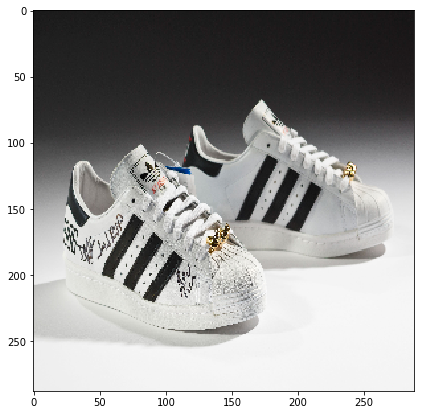

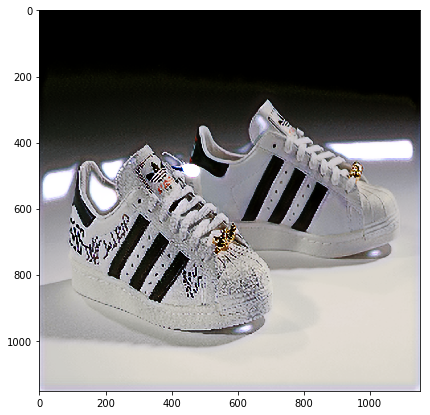

In [58]:
def upscale_pil_img(img_name, model):
    img = Image.open(img_name)
    shp = model.layers[0].output.get_shape()
    img = img.resize((shp[1],shp[2]))
    plt.figure(figsize=(7,7))
    plt.imshow(img)    
    img = np.expand_dims(np.array(img),0)
    p = model.predict(img)
    plt.figure(figsize=(7,7))
    plt.imshow(p[0].astype('uint8'))
    
upscale_pil_img('img/shoes.jpg', high_res_model)    

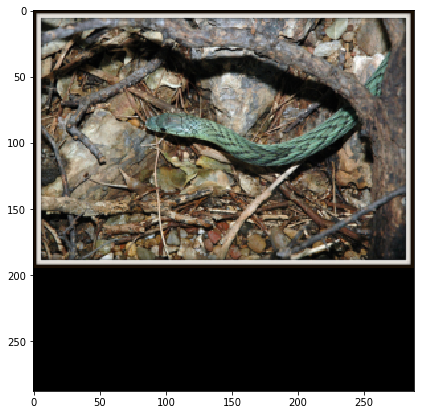

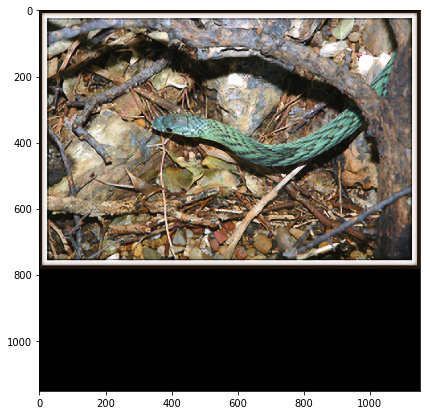

In [64]:
def upscale_bcolz_img(input_arr, index, model):
    plt.figure(figsize=(7,7))
    plt.imshow(input_arr[index].astype('uint8'))
    p = model.predict(np.expand_dims(input_arr[index],0))
    plt.figure(figsize=(7,7))
    plt.imshow(p[0].astype('uint8'))

upscale_bcolz_img(high_res_imgs, 333, high_res_model)